In [1]:
# 1.0 - Obtención y Unificación de Datos Médicos
# ==============================================================================
# Este notebook se encarga de:
# 1. Descargar el dataset 'CodiEsp' (Casos clínicos en Español).
# 2. Descargar y procesar 'MTSamples' (Casos clínicos en Inglés).
# 3. Traducir y adaptar las etiquetas para unificar ambos mundos.
# 4. Generar un dataset maestro balanceado y listo para el preprocesamiento.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datasets import load_dataset
from deep_translator import GoogleTranslator
from tqdm.notebook import tqdm

print("✅ librerías cargadas.")

✅ librerías cargadas.


In [2]:
# Configuración de Rutas
RAW_DATA_PATH = '../data/raw/'
PROCESSED_DATA_PATH = '../data/processed/'

# Crear carpetas si no existen
os.makedirs(RAW_DATA_PATH, exist_ok=True)
os.makedirs(PROCESSED_DATA_PATH, exist_ok=True)

# Configuración para que las tablas se vean esteticamente agradables
pd.set_option('display.max_colwidth', 150)

print("✅ Entorno configurado")

✅ Entorno configurado


In [3]:
print("📥 Cargando dataset CodiEsp desde HuggingFace...")

# 1. Descarga
try:
    ds = load_dataset("bigbio/codiesp", "codiesp_D_bigbio_text", trust_remote_code=True)
    df_codiesp = pd.DataFrame(ds['train'])
except Exception as e:
    print(f"❌ Error descargando CodiEsp: {e}")

# 2. Diccionario de Mapeo (CIE-10 -> Especialidad)
mapa_especialidades = {
    'A': 'Infecciosas/Parasitarias', 'B': 'Infecciosas/Parasitarias', 'C': 'Oncología (Tumores)',
    'D': 'Sangre/Inmunología', 'E': 'Endocrinología/Nutrición', 'F': 'Psiquiatría/Mental',
    'G': 'Neurología', 'H': 'Oftalmología/ORL', 'I': 'Cardiología/Circulatorio', 'J': 'Respiratorio/Neumología',
    'K': 'Gastroenterología/Digestivo', 'L': 'Dermatología', 'M': 'Traumatología/Muscular', 'N': 'Urología/Renal',
    'O': 'Ginecología/Obstetricia', 'P' : 'Pediatría', 'R': 'Medicina General', 
    'S': 'Traumatología/Muscular', 'T': 'Medicina General', 'V' : 'Urgencias/Trauma',
    'W': 'Urgencias/Trauma', 'X': 'Urgencias/Trauma', 'Y': 'Urgencias/Trauma', 'Z': 'Medicina General'
    }

def clasificar_cie10(lista_labels):
    if not isinstance(lista_labels, list) or len(lista_labels) == 0:
        return 'Medicina General'
    codigo = lista_labels[0]
    letra = str(codigo)[0].upper()
    return mapa_especialidades.get(letra, 'Medicina General')

# 3. Procesamiento
df_codiesp['especialidad'] = df_codiesp['labels'].apply(clasificar_cie10)
df_codiesp = df_codiesp.rename(columns={'text': 'sintomas'})
df_codiesp = df_codiesp[['sintomas', 'especialidad']] # Solo columnas útiles

print(f"✅ CodiEsp procesado: {len(df_codiesp)} filas.")
display(df_codiesp.head(2))

📥 Cargando dataset CodiEsp desde HuggingFace...
✅ CodiEsp procesado: 500 filas.


,sintomas,especialidad
0,Describimos el caso de un varón de 37 años con vida previa activa que refiere dolores osteoarticulares de localización variable en el último mes y...,Urología/Renal
1,Se trata de una mujer de 29 años sometida a un estudio ecográfico pélvico de control tras una ligadura de trompas por vía laparoscópica. Durante e...,Sangre/Inmunología


In [4]:
# Nombre del archivo intermedio para no re-traducir siempre
ARCHIVO_TRADUCIDO = os.path.join(RAW_DATA_PATH, 'mtsamples_translated.csv')

# Mapeo de Inglés a tus etiquetas en Español
mapeo_ingles = {
    'Orthopedic': 'Traumatología/Muscular',
    'Gastroenterology': 'Gastroenterología/Digestivo',
    'Urology': 'Urología/Renal',
    'Neurology': 'Neurología',
    'Ophthalmology': 'Oftalmología/ORL',
    'Cardiovascular / Pulmonary': 'Cardiología/Circulatorio',
    'Obstetrics / Gynecology' : 'Ginecología/Obstetricia',
    'Hematology - Oncology' : 'Oncología (Tumores)',
    'General Medicine' : 'Medicina General',
    'Allergy / Immunology' : 'Sangre/Inmunología',
    'Bariatrics' : 'Endocrinología/Nutrición',
    'Diets and Nutritions' : 'Endocrinología/Nutrición',
    'Endocrinology' : 'Endocrinología/Nutrición',
    'Chiropractic' : 'Traumatología/Muscular',
    'Dermatology' : 'Dermatología',
    'ENT - Otolaryngology' : 'Oftalmología/ORL',
    'Ophthalmology' : 'Oftalmología/ORL',
    'Nephrology' : 'Urología/Renal',
    'Sleep Medicine' : 'Neurología',
    'Speech - Language' : 'Neurología',
    'Neurosurgery' : 'Neurología',
    'Physical Medicine - Rehab' : 'Traumatología/Muscular',
    'Podiatry' : 'Traumatología/Muscular',
    'Rheumatology' : 'Traumatología/Muscular',
    'Psychiatry / Psychology' : 'Psiquiatría/Mental',
    'Dentistry' : 'Odontología',
    'Pediatrics - Neonatal' : 'Pediatría'
    }

if os.path.exists(ARCHIVO_TRADUCIDO):
    print("📂 Archivo traducido encontrado. Cargando directamente...")
    df_mt_ready = pd.read_csv(ARCHIVO_TRADUCIDO)
else:
    print("🇺🇸 Cargando MTSamples original para traducir...")
    try:
        df_en = pd.read_csv(os.path.join(RAW_DATA_PATH, 'mtsamples.csv'))
        
        # Filtrar y Mapear
        df_en['medical_specialty'] = df_en['medical_specialty'].str.strip()
        df_filtered = df_en[df_en['medical_specialty'].isin(mapeo_ingles.keys())].copy()
        df_filtered['especialidad'] = df_filtered['medical_specialty'].map(mapeo_ingles)
        
        # Preparar para traducción
        df_mt_ready = df_filtered[['transcription', 'especialidad']].dropna()
        df_mt_ready = df_mt_ready.rename(columns={'transcription': 'sintomas'})
        
        # TRADUCCIÓN (Esto tarda)
        print("⏳ Iniciando traducción (Google Translator)...")
        traductor = GoogleTranslator(source='en', target='es')
        tqdm.pandas()
        
        # Traducimos solo los primeros 400 caracteres para agilizar
        df_mt_ready['sintomas'] = df_mt_ready['sintomas'].progress_apply(
            lambda x: traductor.translate(x[:400]) if pd.notnull(x) else np.nan
        )
        
        df_mt_ready = df_mt_ready.dropna()
        
        # Guardar copia de seguridad
        df_mt_ready.to_csv(ARCHIVO_TRADUCIDO, index=False)
        print("✅ Traducción completada y guardada.")
        
    except FileNotFoundError:
        print("⚠️ ADVERTENCIA: No se encontró 'mtsamples.csv' en data/raw/. Se omitirá esta fuente.")
        df_mt_ready = pd.DataFrame(columns=['sintomas', 'especialidad'])

print(f"✅ Datos MTSamples listos: {len(df_mt_ready)} filas.")
display(df_mt_ready.head(2))

📂 Archivo traducido encontrado. Cargando directamente...
✅ Datos MTSamples listos: 2505 filas.


,sintomas,especialidad
0,"SUBJETIVO: Esta mujer blanca de 23 años se queja de alergias. Solía ​​tener alergias cuando vivía en Seattle, pero cree que aquí son peores. En ...",Sangre/Inmunología
1,"ANTECEDENTES MÉDICOS ANTERIORES: Tiene dificultad para subir escaleras, dificultad con los asientos de avión, atarse los zapatos, está acostumbrad...",Endocrinología/Nutrición


In [5]:
print("📥 Cargando dataset Ecuador generado...")
df_ds_ec = pd.read_csv(os.path.join(RAW_DATA_PATH, 'dataset_medico_ecuador_20k.csv'))

mapeo_espe_ec = {'Cardiología' : 'Cardiología/Circulatorio',
                 'Dermatología' : 'Dermatología',
                 'Gastroenterología' : 'Gastroenterología/Digestivo',
                 'Neumología' : 'Respiratorio/Neumología',
                 'Neurología' : 'Neurología',
                 'Traumatología' : 'Traumatología/Muscular',
                 'Pediatría' : 'Pediatría',
                 'Emergencias' : 'Urgencias/Trauma',
                 'Dermatología' : 'Dermatología',
                 'Otorrinolaringología' : 'Oftalmología/ORL',
                 'Psiquiatría' : 'Psiquiatría/Mental',
                 'Urología' : 'Urología/Renal',
                 'Oftalmología' : 'Oftalmología/ORL',
                 'Odontología' : 'Odontología',
                 'Endocrinología' : 'Endocrinología/Nutrición',
                 'Infectología' : 'Infecciosas/Parasitarias',
                 'Nefrología' : 'Urología/Renal',
                 'Reumatología' : 'Traumatología/Muscular',
                 'Oncología' : 'Oncología (Tumores)',
                 'Alergología' : 'Sangre/Inmunología',
                 'Medicina General' : 'Medicina General'
                 }

df_ds_ec['especialidad'] = df_ds_ec['especialidad'].str.strip()
df_ds_ec['especialidad'] = df_ds_ec['especialidad'].map(mapeo_espe_ec)

df_ds_ec = df_ds_ec[['sintomas', 'especialidad']].dropna()
                           
print(f"✅ Datos Ecuador listos: {len(df_ds_ec)} filas.")

📥 Cargando dataset Ecuador generado...
✅ Datos Ecuador listos: 19081 filas.


In [6]:
print("🔄 Unificando datasets...")

# 1. Concatenar
df_total = pd.concat([df_codiesp, df_mt_ready, df_ds_ec], ignore_index=True)

# 2. Normalización básica de etiquetas
df_total['especialidad'] = df_total['especialidad'].str.upper().str.strip()

# 3. Eliminar nulos
df_total = df_total.dropna(subset=['sintomas', 'especialidad'])

# 4. Mezclar (Shuffle)
df_total = df_total.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"🚀 DATASET MAESTRO CREADO: {len(df_total)} casos totales.")

🔄 Unificando datasets...
🚀 DATASET MAESTRO CREADO: 22086 casos totales.


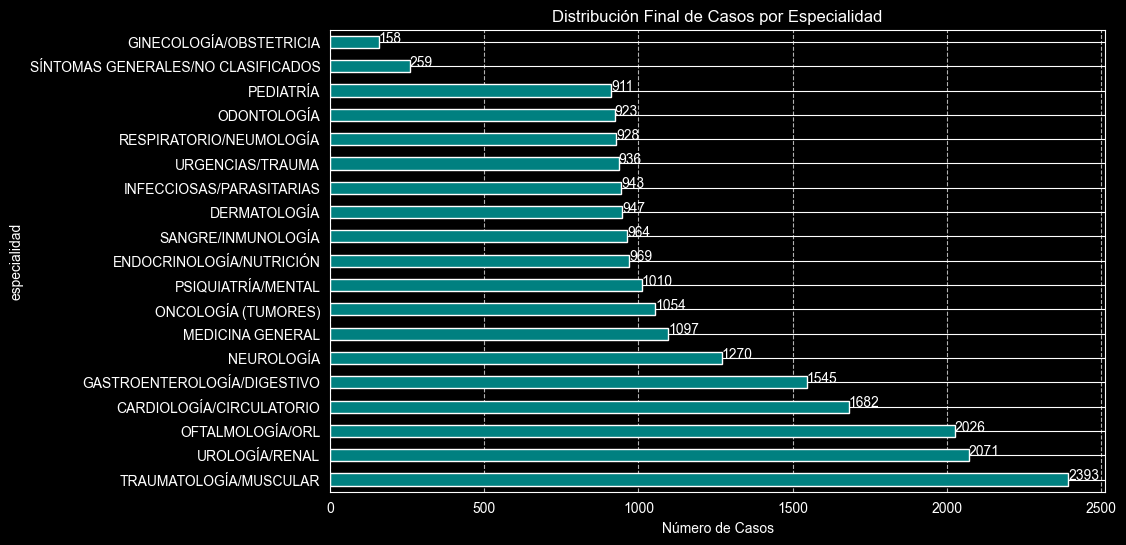

In [7]:
# Verificamos si tenemos suficientes datos por clase
conteo = df_total['especialidad'].value_counts()

plt.figure(figsize=(10,6))
conteo.plot(kind='barh', color='teal')
plt.title('Distribución Final de Casos por Especialidad')
plt.xlabel('Número de Casos')
plt.grid(axis='x', linestyle='--', alpha=0.7)

for index, value in enumerate(conteo):
    plt.text(value, index, str(value))

plt.show()

# Advertencia si hay clases muy pobres
clases_pobres = conteo[conteo < 100]
if not clases_pobres.empty:
    print("⚠️ ADVERTENCIA: Las siguientes clases tienen muy pocos datos (<50):")
    print(clases_pobres.index.tolist())
    print("Considera agruparlas en 'Síntomas Generales/No clasificados' o buscar más datos.")

In [8]:
# Guardamos en la carpeta processed
OUTPUT_FILE = os.path.join(PROCESSED_DATA_PATH, 'datos_triaje_unificados.csv')

df_total.to_csv(OUTPUT_FILE, index=False)

print(f"💾 Archivo guardado exitosamente en: {OUTPUT_FILE}")
print("¡Listo para pasar a la fase de preprocesamiento (2.0)!")

💾 Archivo guardado exitosamente en: ../data/processed/datos_triaje_unificados.csv
¡Listo para pasar a la fase de preprocesamiento (2.0)!
